In [1]:
# Gibson-Schwartz model

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Model parameters
alpha = 0.05       # Spot price drift
sigma_S = 0.2      # Spot price volatility
kappa = 0.3        # Speed of mean reversion for convenience yield
theta = 0.02       # Long-term equilibrium convenience yield
sigma_Y = 0.1      # Convenience yield volatility
rho = -0.5         # Correlation between spot price and convenience yield
S0 = 50            # Initial spot price
Y0 = 0.02          # Initial convenience yield
T = 2.0            # Time horizon in years
N = 250            # Number of time steps
M = 1000           # Number of simulations
dt = T / N         # Time step size

In [2]:
# Simulate the Stochastic Processes

# Generate correlated Wiener processes
dW_S = np.random.normal(0, np.sqrt(dt), (M, N))
dW_Y = np.random.normal(0, np.sqrt(dt), (M, N))
dW_Y = rho * dW_S + np.sqrt(1 - rho**2) * dW_Y  # Apply correlation

# Initialize spot price and convenience yield paths
S = np.zeros((M, N+1))
Y = np.zeros((M, N+1))
S[:, 0] = S0
Y[:, 0] = Y0

# Simulate the processes with Euler discretization
for t in range(1, N+1):
    S[:, t] = S[:, t-1] * np.exp((alpha - 0.5 * sigma_S**2) * dt + sigma_S * dW_S[:, t-1])
    Y[:, t] = Y[:, t-1] + kappa * (theta - Y[:, t-1]) * dt + sigma_Y * dW_Y[:, t-1]

In [3]:
# Compute forward prices 

# Function to compute forward price
def forward_price(S_t, Y_t, T_t):
    B = (1 - np.exp(-kappa * T_t)) / kappa
    A = - (B * theta - (sigma_Y**2 / (2 * kappa**2)) * (B**2))
    return S_t * np.exp(A + B * Y_t)

# Compute forward prices for different maturities
maturities = np.array([0.25, 0.5, 1.0, 2.0])  # 3M, 6M, 1Y, 2Y
F_curves = {T_t: forward_price(S[:, -1], Y[:, -1], T_t) for T_t in maturities}

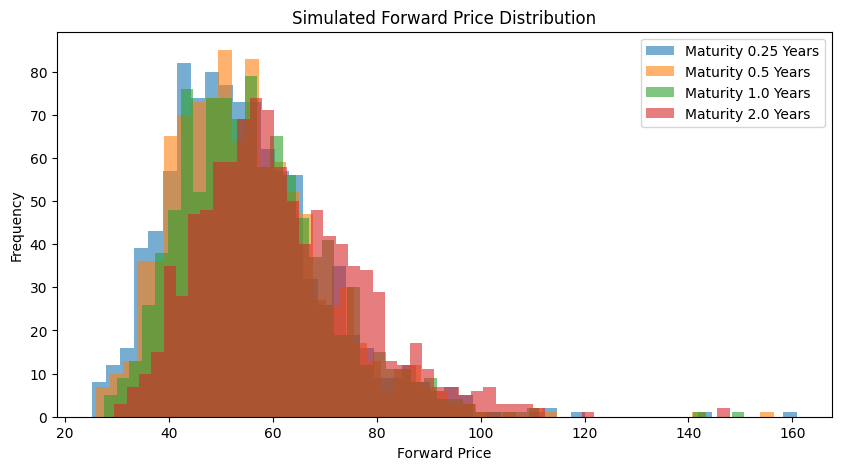

In [4]:
# Plot simulated forward curves

plt.figure(figsize=(10, 5))
for T_t, F in F_curves.items():
    plt.hist(F, bins=50, alpha=0.6, label=f'Maturity {T_t} Years')

plt.xlabel('Forward Price')
plt.ylabel('Frequency')
plt.title('Simulated Forward Price Distribution')
plt.legend()
plt.show()

In [15]:
# Python implementation for MLE paramters estimation

import scipy.optimize as opt

# Load historical spot prices and inferred convenience yield
#spot_prices = np.array([50, 51, 49, 52, 53, 55, 54, 56])  # Example data
spot_prices = np.random.uniform(low=40, high=60, size=100)  # Example data
log_returns = np.diff(np.log(spot_prices))  # Log returns

# Initial parameter guesses
alpha_init = 0.05
sigma_S_init = 0.2
kappa_init = 0.3
theta_init = 0.02
sigma_Y_init = 0.1
rho_init = -0.5

params_init = [alpha_init, sigma_S_init, kappa_init, theta_init, sigma_Y_init, rho_init]

# Log-likelihood function
def negative_log_likelihood(params):
    alpha, sigma_S, kappa, theta, sigma_Y, rho = params
    N = len(log_returns)
    
    # Compute residuals
    epsilon_S = log_returns - (alpha - 0.5 * sigma_S**2)
    epsilon_Y = np.diff(spot_prices) - kappa * (theta - spot_prices[:-1])
    
    # Compute covariance term
    covariance = np.cov(epsilon_S, epsilon_Y)[0, 1]
    
    # Log-likelihood
    likelihood = -N/2 * np.log(2 * np.pi) - N * np.log(sigma_S * sigma_Y * np.sqrt(1 - rho**2))
    likelihood -= (1 / (2 * (1 - rho**2))) * np.sum(
        (epsilon_S**2 / sigma_S**2) + (epsilon_Y**2 / sigma_Y**2) - 2 * rho * epsilon_S * epsilon_Y / (sigma_S * sigma_Y)
    )
    
    return -likelihood  # Negative log-likelihood for minimization

In [18]:
# Optimize parameters
opt_params = opt.minimize(negative_log_likelihood, params_init, method='L-BFGS-B',
                          bounds=[(0, None), (0, None), (0, None), (None, None), (0, None), (-1, 1)])

print("Estimated Parameters:", opt_params.x)

Estimated Parameters: [0.03247832 0.09364444 0.         0.0250632  1.87824199 0.55353044]


C:\Users\lukas\AppData\Local\Temp\ipykernel_38148\598291595.py:33: RuntimeWarning: divide by zero encountered in log
  likelihood = -N/2 * np.log(2 * np.pi) - N * np.log(sigma_S * sigma_Y * np.sqrt(1 - rho**2))
C:\Users\lukas\AppData\Local\Temp\ipykernel_38148\598291595.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  likelihood -= (1 / (2 * (1 - rho**2))) * np.sum(
C:\Users\lukas\AppData\Local\Temp\ipykernel_38148\598291595.py:35: RuntimeWarning: divide by zero encountered in divide
  (epsilon_S**2 / sigma_S**2) + (epsilon_Y**2 / sigma_Y**2) - 2 * rho * epsilon_S * epsilon_Y / (sigma_S * sigma_Y)
C:\Users\lukas\AppData\Local\Temp\ipykernel_38148\598291595.py:35: RuntimeWarning: invalid value encountered in subtract
  (epsilon_S**2 / sigma_S**2) + (epsilon_Y**2 / sigma_Y**2) - 2 * rho * epsilon_S * epsilon_Y / (sigma_S * sigma_Y)
C:\Users\lukas\AppData\Local\Temp\ipykernel_38148\598291595.py:34: RuntimeWarning: invalid value encountered in scalar subtract
  likeliho

In [25]:
alpha = opt_params.x[0]       # Spot price drift
sigma_S = opt_params.x[1]      # Spot price volatility
kappa = opt_params.x[2]        # Speed of mean reversion for convenience yield
theta = opt_params.x[3]       # Long-term equilibrium convenience yield
sigma_Y = opt_params.x[4]      # Convenience yield volatility
rho = opt_params.x[5]         # Correlation between spot price and convenience yield

# Simulate the Stochastic Processes

# Generate correlated Wiener processes
dW_S = np.random.normal(0, np.sqrt(dt), (M, N))
dW_Y = np.random.normal(0, np.sqrt(dt), (M, N))
dW_Y = rho * dW_S + np.sqrt(1 - rho**2) * dW_Y  # Apply correlation

# Initialize spot price and convenience yield paths
S = np.zeros((M, N+1))
Y = np.zeros((M, N+1))
S[:, 0] = S0
Y[:, 0] = Y0

# Simulate the processes with Euler discretization
for t in range(1, N+1):
    S[:, t] = S[:, t-1] * np.exp((alpha - 0.5 * sigma_S**2) * dt + sigma_S * dW_S[:, t-1])
    Y[:, t] = Y[:, t-1] + kappa * (theta - Y[:, t-1]) * dt + sigma_Y * dW_Y[:, t-1]

# Compute forward prices 

# Function to compute forward price
def forward_price(S_t, Y_t, T_t):
    B = (1 - np.exp(-kappa * T_t)) / kappa
    A = - (B * theta - (sigma_Y**2 / (2 * kappa**2)) * (B**2))
    return S_t * np.exp(A + B * Y_t)

# Compute forward prices for different maturities
maturities = np.array([0.25, 0.5, 1.0, 2.0])  # 3M, 6M, 1Y, 2Y
F_curves = {T_t: forward_price(S[:, -1], Y[:, -1], T_t) for T_t in maturities}

C:\Users\lukas\AppData\Local\Temp\ipykernel_38148\3521576574.py:30: RuntimeWarning: invalid value encountered in scalar divide
  B = (1 - np.exp(-kappa * T_t)) / kappa
C:\Users\lukas\AppData\Local\Temp\ipykernel_38148\3521576574.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  A = - (B * theta - (sigma_Y**2 / (2 * kappa**2)) * (B**2))


c:\ProgramData\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\ProgramData\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

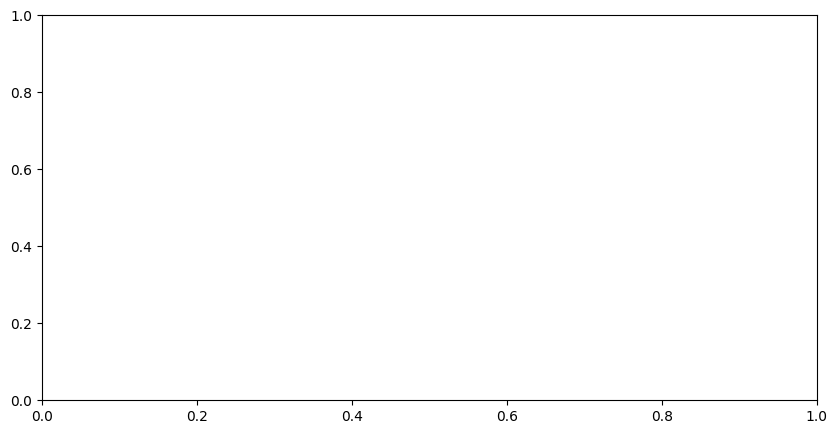

In [26]:
# Plot forward curves

plt.figure(figsize=(10, 5))
for T_t, F in F_curves.items():
    plt.hist(F, bins=50, alpha=0.6, label=f'Maturity {T_t} Years')

plt.xlabel('Forward Price')
plt.ylabel('Frequency')
plt.title('Forward Price Distribution')
plt.legend()
plt.show()

In [8]:
# Heath-Jarrow-Morton (HJM) Model for Power Price Curves

from scipy.optimize import curve_fit

# HJM Model Parameters
T = 1.0  # Total time horizon in years
N = 50   # Number of time steps
M = 1000 # Number of Monte Carlo simulations
dt = T / N  # Time step size


# Load historical forward prices (replace with real data)
def generate_synthetic_data(N=500):
    np.random.seed(42)
    time = np.linspace(0, 10, N)
    base_price = 50 + 5 * np.sin(2 * np.pi * time / 365)
    noise = np.random.normal(0, 2, N)
    jumps = np.random.poisson(0.02, N) * np.random.normal(10, 5, N)
    return time, base_price + noise + jumps

time, F_t = generate_synthetic_data()

# Compute daily log returns
log_returns = np.diff(np.log(F_t))

# Estimate mean-reversion rate (alpha)
def ou_process(t, alpha, mu):
    return mu * (1 - np.exp(-alpha * t))

t_shifted = time[:-1]
popt, _ = curve_fit(ou_process, t_shifted, log_returns, p0=[0.01, 0])
alpha_est = popt[0]

# Estimate volatility (sigma_0)
sigma_est = np.std(log_returns)

# Identify jumps (returns exceeding 3 std deviations)
jump_indices = np.where(np.abs(log_returns) > 3 * sigma_est)[0]
jump_sizes = log_returns[jump_indices]

# Estimate jump parameters
lambda_j_est = len(jump_indices) / (time[-1] - time[0])  # Jumps per year
mu_j_est = np.mean(jump_sizes)
sigma_j_est = np.std(jump_sizes)

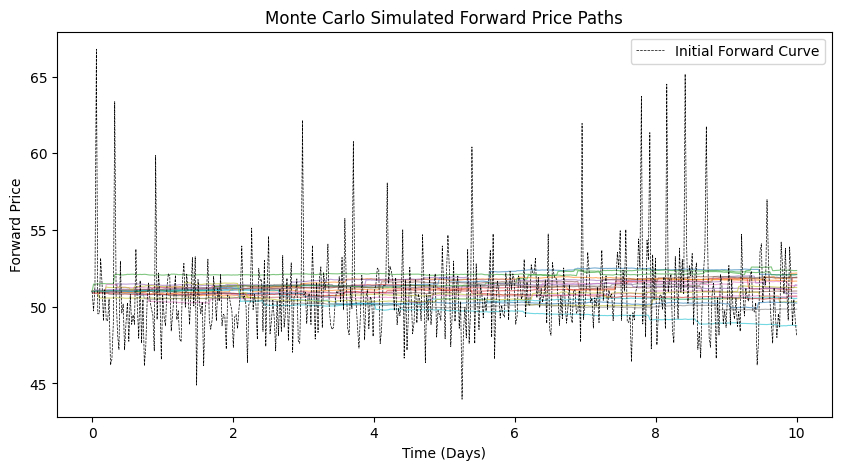

In [11]:
# Monte Carlo Simulation of Forward Prices
M = 1000  # Number of simulations
N = len(time)  # Number of time steps
dt = (time[-1] - time[0]) / N  # Time step size
F_paths = np.zeros((M, N))
F_paths[:, 0] = F_t[0]  # Initialize with first price


for i in range(1, N):
    dW = np.sqrt(dt) * np.random.randn(M)  # Brownian motion
    sigma_t = sigma_est * np.exp(-alpha_est * (time[i] - time[0]))  # Volatility term
    dF = -alpha_est * (F_paths[:, i-1] - F_t[i]) * dt + sigma_t * dW  # HJM Forward Price SDE
    
    # Jump process
    N_jumps = np.random.poisson(lambda_j_est * dt, M)  # Number of jumps
    J = np.random.normal(mu_j_est, sigma_j_est, M) * N_jumps  # Jump size
    
    F_paths[:, i] = F_paths[:, i-1] + dF + J  # Update forward prices with jumps

# Plot Monte Carlo Simulations
plt.figure(figsize=(10, 5))
for i in range(20):  # Plot a subset of paths
    plt.plot(time, F_paths[i, :], lw=0.8, alpha=0.6)
plt.plot(time, F_t, 'k--', lw=0.5, label='Initial Forward Curve')
plt.xlabel('Time (Days)')
plt.ylabel('Forward Price')
plt.title('Monte Carlo Simulated Forward Price Paths')
plt.legend()
plt.show()